# I. Mirror number classification
### 1) MLP (multilayer perceptron) network

*Based on: https://machinelearningmastery.com/tutorial-first-neural-network-python-keras/*

Here we implement our first ML model for the basic task of classifying the number of mirrors in the system, based on the interference pattern. We start with a simple deep neural network - an MLP - which consists of several fully connected layers. 

In [1]:
# necessary imports

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from numpy import loadtxt
import numpy as np
import matplotlib.pyplot as plt

The input data is in the form of a CSV file, where each row has numbers separated by commas. The first value signifies the number of mirrors present in the system; subsequent numbers are the values of total transmittance for equally spaced wavenumbers k. The number of k values is constant through all the rows and depends on the generated data - the more k values, the more dense the probing of the k-space.

Let us load the dataset and visualize some interference pattern.

In [2]:
dataset = loadtxt('data100_40slots_t=050.csv', delimiter=',', skiprows=1)

# number of k samples
k_samples = 100

# number of classes (of mirror numbers)
num_classes = 15

# list of class labels
classes = [f'{class_id}' for class_id in range(6, 21)]

# mirror numbers (the correct classes) in the first column
y = dataset[:,0]

# convenient to have the classes starting from 0, so just subtract 6 from every y
y -= 6

# transmittance values
X = dataset[:,1:]

This dataset we normalize by the maximal values of each sample.

In [3]:
X = X / np.max(X, axis = 1, keepdims = True)

Example plot:

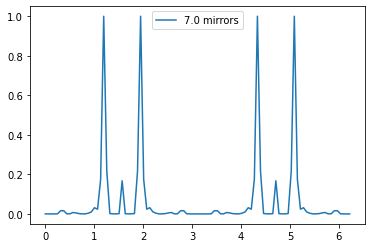

In [4]:
# k-space for plotting
kmin = 0
kmax = 2 * np.pi
ks = np.linspace(kmin, kmax, k_samples, endpoint = False)

which_row = 42200

plt.figure()
plt.plot(ks, X[which_row], label=f'{y[which_row]+3} mirrors')
plt.legend(loc='best')
plt.show()

We will now split the dataset randomly into the training and test parts, borrowing a function from the scikit-learn package.

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify = y, 
                                                    test_size = 0.15,
                                                    random_state = 42)

# the 'stratify = y' argument ensures that the training and testing sets contain the same proportion of each class
# we especially need to watch out for this for the lowest number of mirrors 
# which forms a tiny proportion of the whole dataset:

print('Proportion of 3-mirror elements in the testing set:', list(y_test).count(0) / len(y_test))
print('Proportion of 3-mirror elements in the testing set:', list(y_train).count(0) / len(y_train))

Proportion of 3-mirror elements in the testing set: 0.06666666666666667
Proportion of 3-mirror elements in the testing set: 0.06666666666666667


Checks out. Let us build the network now (with the sizes of hidden layers chosen arbitrarily).

In [6]:
# Define the model
model = Sequential()
model.add(Dense(64, input_dim=k_samples, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(15, activation='sigmoid'))

# The last layer consists of 8 nodes as we generated the data for 3 to 10 mirrors.

We shall define metrics to gauge the performance of our model using a useful function from the sklearn module. To have it evaluated after each epoch of the training, we will wrap it in a Keras callback. This callback will evaluate the classification report and log it to a log dictionary.

In [7]:
from sklearn.metrics import classification_report

classification_report_log_dict = {f'{class_id}' : {'precision': [], 'recall': [], 'f1-score': []} 
                                  for class_id in classes} | {'accuracy': [], 
                                        'macro avg': {'precision': [], 'recall': [], 'f1-score': []},
                                        'weighted avg': {'precision': [], 'recall': [], 'f1-score': []}}

class PerformanceEvaluationCallback(keras.callbacks.Callback):
    def __init__(self, x_test, y_test):
        self.x_test = x_test
        self.y_test = y_test
        
    def on_epoch_end(self, epoch, logs=None):
        print('Evaluating the model...', end = ' ')
        y_pred = self.model.predict(self.x_test, verbose=0, batch_size = len(self.x_test))
        y_pred = np.argmax(y_pred, axis = 1)
        report = classification_report(self.y_test, y_pred, 
                              target_names = classes, output_dict = True)
        for class_id in classes + ['macro avg', 'weighted avg']:
            classification_report_log_dict[class_id]['precision'].append(report[class_id]['precision'])
            classification_report_log_dict[class_id]['recall'].append(report[class_id]['recall'])
            classification_report_log_dict[class_id]['f1-score'].append(report[class_id]['f1-score'])
        
        classification_report_log_dict['accuracy'].append(report['accuracy'])
        print(f"Accuracy: {report['accuracy']}")
        
        
performance_callback = PerformanceEvaluationCallback(X_test, y_test)

Now we compile.

In [8]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')

Set necessary prerequisites and train, using the testing data for validation.

In [9]:
epochs = 2500
batch_size = 128

callbacks = [
    performance_callback,
    
    keras.callbacks.ModelCheckpoint(
        "best_model.h5", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]

history = model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=(X_test, y_test),
    verbose=1
)

Epoch 1/2500
997/997 [==============================] - 1s 956us/step - loss: 2.3525 - val_loss: 2.2411
Evaluating the model... Accuracy: 0.17595555555555556
Epoch 2/2500
997/997 [==============================] - 1s 819us/step - loss: 2.1884 - val_loss: 2.1492
Evaluating the model... Accuracy: 0.19653333333333334
Epoch 3/2500
997/997 [==============================] - 1s 878us/step - loss: 2.1153 - val_loss: 2.0890
Evaluating the model... Accuracy: 0.20982222222222222
Epoch 4/2500
997/997 [==============================] - 1s 899us/step - loss: 2.0664 - val_loss: 2.0553
Evaluating the model... Accuracy: 0.21884444444444445
Epoch 5/2500
997/997 [==============================] - 1s 889us/step - loss: 2.0313 - val_loss: 2.0274
Evaluating the model... Accuracy: 0.22395555555555555
Epoch 6/2500
997/997 [==============================] - 1s 824us/step - loss: 2.0023 - val_loss: 1.9958
Evaluating the model... Accuracy: 0.23475555555555555
Epoch 7/2500
997/997 [==============================

997/997 [==============================] - 1s 928us/step - loss: 1.5709 - val_loss: 1.5882
Evaluating the model... Accuracy: 0.38911111111111113
Epoch 54/2500
997/997 [==============================] - 1s 772us/step - loss: 1.5660 - val_loss: 1.5757
Evaluating the model... Accuracy: 0.3915111111111111
Epoch 55/2500
997/997 [==============================] - 1s 837us/step - loss: 1.5630 - val_loss: 1.5628
Evaluating the model... Accuracy: 0.4036
Epoch 56/2500
997/997 [==============================] - 1s 768us/step - loss: 1.5566 - val_loss: 1.5713
Evaluating the model... Accuracy: 0.39666666666666667
Epoch 57/2500
997/997 [==============================] - 1s 754us/step - loss: 1.5539 - val_loss: 1.5511
Evaluating the model... Accuracy: 0.4091111111111111
Epoch 58/2500
997/997 [==============================] - 1s 761us/step - loss: 1.5522 - val_loss: 1.5510
Evaluating the model... Accuracy: 0.4023555555555556
Epoch 59/2500
997/997 [==============================] - 1s 768us/step - los

997/997 [==============================] - 1s 786us/step - loss: 1.4092 - val_loss: 1.4242
Evaluating the model... Accuracy: 0.44822222222222224
Epoch 106/2500
997/997 [==============================] - 1s 763us/step - loss: 1.4076 - val_loss: 1.4199
Evaluating the model... Accuracy: 0.44653333333333334
Epoch 107/2500
997/997 [==============================] - 1s 777us/step - loss: 1.4037 - val_loss: 1.4129
Evaluating the model... Accuracy: 0.4534666666666667
Epoch 108/2500
997/997 [==============================] - 1s 773us/step - loss: 1.4012 - val_loss: 1.4142
Evaluating the model... Accuracy: 0.45093333333333335
Epoch 109/2500
997/997 [==============================] - 1s 777us/step - loss: 1.4006 - val_loss: 1.4060
Evaluating the model... Accuracy: 0.4496888888888889
Epoch 110/2500
997/997 [==============================] - 1s 782us/step - loss: 1.3974 - val_loss: 1.4243
Evaluating the model... Accuracy: 0.4431111111111111
Epoch 111/2500
997/997 [==============================] - 

997/997 [==============================] - 1s 806us/step - loss: 1.3196 - val_loss: 1.3349
Evaluating the model... Accuracy: 0.4776888888888889
Epoch 158/2500
997/997 [==============================] - 1s 786us/step - loss: 1.3194 - val_loss: 1.3438
Evaluating the model... Accuracy: 0.47742222222222225
Epoch 159/2500
997/997 [==============================] - 1s 771us/step - loss: 1.3169 - val_loss: 1.3355
Evaluating the model... Accuracy: 0.47746666666666665
Epoch 160/2500
997/997 [==============================] - 1s 770us/step - loss: 1.3180 - val_loss: 1.3233
Evaluating the model... Accuracy: 0.4844
Epoch 161/2500
997/997 [==============================] - 1s 790us/step - loss: 1.3170 - val_loss: 1.3425
Evaluating the model... Accuracy: 0.47284444444444446
Epoch 162/2500
997/997 [==============================] - 1s 784us/step - loss: 1.3144 - val_loss: 1.3230
Evaluating the model... Accuracy: 0.4812444444444444
Epoch 163/2500
997/997 [==============================] - 1s 766us/ste

997/997 [==============================] - 1s 900us/step - loss: 1.2591 - val_loss: 1.2765
Evaluating the model... Accuracy: 0.49937777777777775
Epoch 210/2500
997/997 [==============================] - 1s 822us/step - loss: 1.2599 - val_loss: 1.2918
Evaluating the model... Accuracy: 0.49275555555555556
Epoch 211/2500
997/997 [==============================] - 1s 767us/step - loss: 1.2601 - val_loss: 1.2782
Evaluating the model... Accuracy: 0.4940888888888889
Epoch 212/2500
997/997 [==============================] - 1s 825us/step - loss: 1.2580 - val_loss: 1.2886
Evaluating the model... Accuracy: 0.49844444444444447
Epoch 213/2500
997/997 [==============================] - 1s 864us/step - loss: 1.2571 - val_loss: 1.2820
Evaluating the model... Accuracy: 0.5010666666666667
Epoch 214/2500
997/997 [==============================] - 1s 904us/step - loss: 1.2553 - val_loss: 1.2801
Evaluating the model... Accuracy: 0.5014666666666666
Epoch 215/2500
997/997 [==============================] - 

997/997 [==============================] - 1s 910us/step - loss: 1.2169 - val_loss: 1.2296
Evaluating the model... Accuracy: 0.5128
Epoch 262/2500
997/997 [==============================] - 1s 853us/step - loss: 1.2160 - val_loss: 1.2342
Evaluating the model... Accuracy: 0.5112444444444444
Epoch 263/2500
997/997 [==============================] - 1s 1ms/step - loss: 1.2141 - val_loss: 1.2559
Evaluating the model... Accuracy: 0.5083111111111112
Epoch 264/2500
997/997 [==============================] - 1s 879us/step - loss: 1.2138 - val_loss: 1.2444
Evaluating the model... Accuracy: 0.5113777777777778
Epoch 265/2500
997/997 [==============================] - 1s 833us/step - loss: 1.2121 - val_loss: 1.2174
Evaluating the model... Accuracy: 0.5160444444444444
Epoch 266/2500
997/997 [==============================] - 1s 781us/step - loss: 1.2114 - val_loss: 1.2394
Evaluating the model... Accuracy: 0.5116444444444445
Epoch 267/2500
997/997 [==============================] - 1s 812us/step - l

997/997 [==============================] - 1s 894us/step - loss: 1.1813 - val_loss: 1.2174
Evaluating the model... Accuracy: 0.5216
Epoch 314/2500
997/997 [==============================] - 1s 830us/step - loss: 1.1807 - val_loss: 1.1960
Evaluating the model... Accuracy: 0.5304888888888889
Epoch 315/2500
997/997 [==============================] - 1s 810us/step - loss: 1.1816 - val_loss: 1.1943
Evaluating the model... Accuracy: 0.5265777777777778
Epoch 316/2500
997/997 [==============================] - 1s 842us/step - loss: 1.1789 - val_loss: 1.1979
Evaluating the model... Accuracy: 0.5229777777777778
Epoch 317/2500
997/997 [==============================] - 1s 837us/step - loss: 1.1774 - val_loss: 1.2169
Evaluating the model... Accuracy: 0.5167555555555555
Epoch 318/2500
997/997 [==============================] - 1s 879us/step - loss: 1.1785 - val_loss: 1.1897
Evaluating the model... Accuracy: 0.5277333333333334
Epoch 319/2500
997/997 [==============================] - 1s 1ms/step - l

997/997 [==============================] - 1s 1ms/step - loss: 1.1507 - val_loss: 1.1634
Evaluating the model... Accuracy: 0.5390666666666667
Epoch 366/2500
997/997 [==============================] - 1s 971us/step - loss: 1.1506 - val_loss: 1.1632
Evaluating the model... Accuracy: 0.5425777777777778
Epoch 367/2500
997/997 [==============================] - 1s 1ms/step - loss: 1.1494 - val_loss: 1.1767
Evaluating the model... Accuracy: 0.5364888888888889
Epoch 368/2500
997/997 [==============================] - 1s 1ms/step - loss: 1.1499 - val_loss: 1.2002
Evaluating the model... Accuracy: 0.5288888888888889
Epoch 369/2500
997/997 [==============================] - 1s 1ms/step - loss: 1.1491 - val_loss: 1.1740
Evaluating the model... Accuracy: 0.5382222222222223
Epoch 370/2500
997/997 [==============================] - 1s 818us/step - loss: 1.1476 - val_loss: 1.1633
Evaluating the model... Accuracy: 0.5431555555555555
Epoch 371/2500
997/997 [==============================] - 1s 1ms/step

997/997 [==============================] - 1s 1ms/step - loss: 1.1251 - val_loss: 1.1592
Evaluating the model... Accuracy: 0.5413333333333333
Epoch 418/2500
997/997 [==============================] - 1s 997us/step - loss: 1.1256 - val_loss: 1.1381
Evaluating the model... Accuracy: 0.5421333333333334
Epoch 419/2500
997/997 [==============================] - 1s 1ms/step - loss: 1.1242 - val_loss: 1.1298
Evaluating the model... Accuracy: 0.5472
Epoch 420/2500
997/997 [==============================] - 1s 868us/step - loss: 1.1228 - val_loss: 1.1364
Evaluating the model... Accuracy: 0.5452
Epoch 421/2500
997/997 [==============================] - 1s 862us/step - loss: 1.1227 - val_loss: 1.1461
Evaluating the model... Accuracy: 0.5450222222222222
Epoch 422/2500
997/997 [==============================] - 1s 795us/step - loss: 1.1240 - val_loss: 1.1630
Evaluating the model... Accuracy: 0.542
Epoch 423/2500
997/997 [==============================] - 1s 883us/step - loss: 1.1230 - val_loss: 1.1

997/997 [==============================] - 1s 826us/step - loss: 1.1007 - val_loss: 1.1401
Evaluating the model... Accuracy: 0.5466666666666666
Epoch 470/2500
997/997 [==============================] - 1s 874us/step - loss: 1.0983 - val_loss: 1.1052
Evaluating the model... Accuracy: 0.5594222222222223
Epoch 471/2500
997/997 [==============================] - 1s 1ms/step - loss: 1.0984 - val_loss: 1.1390
Evaluating the model... Accuracy: 0.5507111111111112
Epoch 472/2500
997/997 [==============================] - 1s 828us/step - loss: 1.0985 - val_loss: 1.1536
Evaluating the model... Accuracy: 0.5449333333333334
Epoch 473/2500
997/997 [==============================] - 1s 821us/step - loss: 1.1009 - val_loss: 1.1052
Evaluating the model... Accuracy: 0.5591555555555555
Epoch 474/2500
997/997 [==============================] - 1s 840us/step - loss: 1.1002 - val_loss: 1.1156
Evaluating the model... Accuracy: 0.5580888888888889
Epoch 475/2500
997/997 [==============================] - 1s 81

997/997 [==============================] - 1s 769us/step - loss: 1.0821 - val_loss: 1.1345
Evaluating the model... Accuracy: 0.5498222222222222
Epoch 522/2500
997/997 [==============================] - 1s 773us/step - loss: 1.0789 - val_loss: 1.1029
Evaluating the model... Accuracy: 0.5554222222222223
Epoch 523/2500
997/997 [==============================] - 1s 853us/step - loss: 1.0808 - val_loss: 1.0852
Evaluating the model... Accuracy: 0.5644444444444444
Epoch 524/2500
997/997 [==============================] - 1s 817us/step - loss: 1.0785 - val_loss: 1.0966
Evaluating the model... Accuracy: 0.5586666666666666
Epoch 525/2500
997/997 [==============================] - 1s 794us/step - loss: 1.0764 - val_loss: 1.1042
Evaluating the model... Accuracy: 0.5584
Epoch 526/2500
997/997 [==============================] - 1s 772us/step - loss: 1.0812 - val_loss: 1.1081
Evaluating the model... Accuracy: 0.5569777777777778
Epoch 527/2500
997/997 [==============================] - 1s 804us/step -

997/997 [==============================] - 1s 778us/step - loss: 1.0177 - val_loss: 1.0300
Evaluating the model... Accuracy: 0.5860444444444445
Epoch 574/2500
997/997 [==============================] - 1s 962us/step - loss: 1.0168 - val_loss: 1.0335
Evaluating the model... Accuracy: 0.5844444444444444
Epoch 575/2500
997/997 [==============================] - 1s 853us/step - loss: 1.0159 - val_loss: 1.0356
Evaluating the model... Accuracy: 0.5848
Epoch 576/2500
997/997 [==============================] - 1s 830us/step - loss: 1.0169 - val_loss: 1.0373
Evaluating the model... Accuracy: 0.582
Epoch 577/2500
997/997 [==============================] - 1s 879us/step - loss: 1.0157 - val_loss: 1.0338
Evaluating the model... Accuracy: 0.5874222222222222
Epoch 578/2500
997/997 [==============================] - 1s 765us/step - loss: 1.0151 - val_loss: 1.0303
Evaluating the model... Accuracy: 0.5890666666666666
Epoch 579/2500
997/997 [==============================] - 1s 886us/step - loss: 1.0143

997/997 [==============================] - 1s 765us/step - loss: 0.9982 - val_loss: 1.0174
Evaluating the model... Accuracy: 0.5925777777777778
Epoch 626/2500
997/997 [==============================] - 1s 789us/step - loss: 0.9968 - val_loss: 1.0199
Evaluating the model... Accuracy: 0.5889333333333333
Epoch 627/2500
997/997 [==============================] - 1s 772us/step - loss: 0.9989 - val_loss: 1.0279
Evaluating the model... Accuracy: 0.5881333333333333
Epoch 628/2500
997/997 [==============================] - 1s 778us/step - loss: 0.9953 - val_loss: 1.0129
Evaluating the model... Accuracy: 0.5924888888888888
Epoch 629/2500
997/997 [==============================] - 1s 914us/step - loss: 0.9962 - val_loss: 1.0261
Evaluating the model... Accuracy: 0.5867111111111111
Epoch 630/2500
997/997 [==============================] - 1s 954us/step - loss: 0.9968 - val_loss: 1.0287
Evaluating the model... Accuracy: 0.5896
Epoch 631/2500
997/997 [==============================] - 1s 902us/step -

997/997 [==============================] - 1s 803us/step - loss: 0.9830 - val_loss: 1.0220
Evaluating the model... Accuracy: 0.5870222222222222
Epoch 678/2500
997/997 [==============================] - 1s 759us/step - loss: 0.9832 - val_loss: 1.0010
Evaluating the model... Accuracy: 0.5998666666666667
Epoch 679/2500
997/997 [==============================] - 1s 779us/step - loss: 0.9820 - val_loss: 0.9989
Evaluating the model... Accuracy: 0.6005333333333334
Epoch 680/2500
997/997 [==============================] - 1s 777us/step - loss: 0.9821 - val_loss: 0.9981
Evaluating the model... Accuracy: 0.5987111111111111
Epoch 681/2500
997/997 [==============================] - 1s 781us/step - loss: 0.9816 - val_loss: 1.0030
Evaluating the model... Accuracy: 0.6025333333333334
Epoch 682/2500
997/997 [==============================] - 1s 786us/step - loss: 0.9825 - val_loss: 0.9922
Evaluating the model... Accuracy: 0.6056888888888889
Epoch 683/2500
997/997 [==============================] - 1s 

Epoch 729/2500
997/997 [==============================] - 1s 765us/step - loss: 0.9708 - val_loss: 0.9787
Evaluating the model... Accuracy: 0.6074666666666667
Epoch 730/2500
997/997 [==============================] - 1s 769us/step - loss: 0.9712 - val_loss: 0.9890
Evaluating the model... Accuracy: 0.6046666666666667
Epoch 731/2500
997/997 [==============================] - 1s 777us/step - loss: 0.9683 - val_loss: 0.9957
Evaluating the model... Accuracy: 0.6002666666666666
Epoch 732/2500
997/997 [==============================] - 1s 769us/step - loss: 0.9688 - val_loss: 0.9950
Evaluating the model... Accuracy: 0.6063555555555555
Epoch 733/2500
997/997 [==============================] - 1s 777us/step - loss: 0.9704 - val_loss: 0.9900
Evaluating the model... Accuracy: 0.6023111111111111
Epoch 734/2500
997/997 [==============================] - 1s 776us/step - loss: 0.9682 - val_loss: 0.9891
Evaluating the model... Accuracy: 0.6028444444444444
Epoch 735/2500
997/997 [======================

997/997 [==============================] - 1s 791us/step - loss: 0.9291 - val_loss: 0.9534
Evaluating the model... Accuracy: 0.6223555555555556
Epoch 782/2500
997/997 [==============================] - 1s 789us/step - loss: 0.9288 - val_loss: 0.9464
Evaluating the model... Accuracy: 0.6224444444444445
Epoch 783/2500
997/997 [==============================] - 1s 772us/step - loss: 0.9270 - val_loss: 0.9452
Evaluating the model... Accuracy: 0.6227111111111111
Epoch 784/2500
997/997 [==============================] - 1s 769us/step - loss: 0.9287 - val_loss: 0.9470
Evaluating the model... Accuracy: 0.6224444444444445
Epoch 785/2500
997/997 [==============================] - 1s 783us/step - loss: 0.9281 - val_loss: 0.9465
Evaluating the model... Accuracy: 0.6201777777777778
Epoch 786/2500
997/997 [==============================] - 1s 839us/step - loss: 0.9274 - val_loss: 0.9452
Evaluating the model... Accuracy: 0.6198222222222223
Epoch 787/2500
997/997 [==============================] - 1s 

997/997 [==============================] - 1s 778us/step - loss: 0.9020 - val_loss: 0.9243
Evaluating the model... Accuracy: 0.6312888888888889
Epoch 834/2500
997/997 [==============================] - 1s 773us/step - loss: 0.9013 - val_loss: 0.9272
Evaluating the model... Accuracy: 0.6306222222222222
Epoch 835/2500
997/997 [==============================] - 1s 792us/step - loss: 0.9014 - val_loss: 0.9442
Evaluating the model... Accuracy: 0.6228888888888889
Epoch 836/2500
997/997 [==============================] - 1s 773us/step - loss: 0.9010 - val_loss: 0.9328
Evaluating the model... Accuracy: 0.6277333333333334
Epoch 837/2500
997/997 [==============================] - 1s 776us/step - loss: 0.9008 - val_loss: 0.9299
Evaluating the model... Accuracy: 0.6310666666666667
Epoch 838/2500
997/997 [==============================] - 1s 774us/step - loss: 0.9005 - val_loss: 0.9273
Evaluating the model... Accuracy: 0.6297333333333334
Epoch 839/2500
997/997 [==============================] - 1s 

997/997 [==============================] - 1s 774us/step - loss: 0.8948 - val_loss: 0.9185
Evaluating the model... Accuracy: 0.6364444444444445
Epoch 886/2500
997/997 [==============================] - 1s 769us/step - loss: 0.8958 - val_loss: 0.9166
Evaluating the model... Accuracy: 0.6355111111111111
Epoch 887/2500
997/997 [==============================] - 1s 768us/step - loss: 0.8940 - val_loss: 0.9248
Evaluating the model... Accuracy: 0.6329333333333333
Epoch 888/2500
997/997 [==============================] - 1s 782us/step - loss: 0.8945 - val_loss: 0.9217
Evaluating the model... Accuracy: 0.6353777777777778
Epoch 889/2500
997/997 [==============================] - 1s 787us/step - loss: 0.8935 - val_loss: 0.9229
Evaluating the model... Accuracy: 0.6312888888888889
Epoch 890/2500
997/997 [==============================] - 1s 764us/step - loss: 0.8943 - val_loss: 0.9216
Evaluating the model... Accuracy: 0.6333777777777778
Epoch 891/2500
997/997 [==============================] - 1s 

997/997 [==============================] - 1s 783us/step - loss: 0.8853 - val_loss: 0.9117
Evaluating the model... Accuracy: 0.6348444444444444
Epoch 938/2500
997/997 [==============================] - 1s 776us/step - loss: 0.8853 - val_loss: 0.9081
Evaluating the model... Accuracy: 0.6396444444444445
Epoch 939/2500
997/997 [==============================] - 1s 818us/step - loss: 0.8847 - val_loss: 0.9084
Evaluating the model... Accuracy: 0.6380888888888889
Epoch 940/2500
997/997 [==============================] - 1s 853us/step - loss: 0.8847 - val_loss: 0.9076
Evaluating the model... Accuracy: 0.6378222222222222
Epoch 941/2500
997/997 [==============================] - 1s 881us/step - loss: 0.8853 - val_loss: 0.9077
Evaluating the model... Accuracy: 0.6389333333333334
Epoch 942/2500
997/997 [==============================] - 1s 887us/step - loss: 0.8846 - val_loss: 0.9079
Evaluating the model... Accuracy: 0.6369777777777778
Epoch 943/2500
997/997 [==============================] - 1s 

997/997 [==============================] - 1s 735us/step - loss: 0.8800 - val_loss: 0.9030
Evaluating the model... Accuracy: 0.6408888888888888
Epoch 990/2500
997/997 [==============================] - 1s 753us/step - loss: 0.8796 - val_loss: 0.9038
Evaluating the model... Accuracy: 0.6412
Epoch 991/2500
997/997 [==============================] - 1s 764us/step - loss: 0.8793 - val_loss: 0.9037
Evaluating the model... Accuracy: 0.64
Epoch 992/2500
997/997 [==============================] - 1s 758us/step - loss: 0.8797 - val_loss: 0.8988
Evaluating the model... Accuracy: 0.6431555555555556
Epoch 993/2500
997/997 [==============================] - 1s 754us/step - loss: 0.8798 - val_loss: 0.9017
Evaluating the model... Accuracy: 0.6374222222222222
Epoch 994/2500
997/997 [==============================] - 1s 759us/step - loss: 0.8793 - val_loss: 0.9027
Evaluating the model... Accuracy: 0.6407555555555555
Epoch 995/2500
997/997 [==============================] - 1s 735us/step - loss: 0.8792 

997/997 [==============================] - 1s 944us/step - loss: 0.8749 - val_loss: 0.9156
Evaluating the model... Accuracy: 0.6332888888888889
Epoch 1042/2500
997/997 [==============================] - 1s 971us/step - loss: 0.8751 - val_loss: 0.8980
Evaluating the model... Accuracy: 0.6377333333333334
Epoch 1043/2500
997/997 [==============================] - 1s 831us/step - loss: 0.8745 - val_loss: 0.8989
Evaluating the model... Accuracy: 0.6411111111111111
Epoch 1044/2500
997/997 [==============================] - 1s 864us/step - loss: 0.8744 - val_loss: 0.9016
Evaluating the model... Accuracy: 0.6399555555555556
Epoch 1045/2500
997/997 [==============================] - 1s 897us/step - loss: 0.8747 - val_loss: 0.9029
Evaluating the model... Accuracy: 0.6388444444444444
Epoch 1046/2500
997/997 [==============================] - 1s 828us/step - loss: 0.8735 - val_loss: 0.9008
Evaluating the model... Accuracy: 0.6378222222222222
Epoch 1047/2500
997/997 [==============================]

997/997 [==============================] - 1s 828us/step - loss: 0.8703 - val_loss: 0.8949
Evaluating the model... Accuracy: 0.6387555555555555
Epoch 1094/2500
997/997 [==============================] - 1s 819us/step - loss: 0.8699 - val_loss: 0.8922
Evaluating the model... Accuracy: 0.6442222222222223
Epoch 1095/2500
997/997 [==============================] - 1s 824us/step - loss: 0.8700 - val_loss: 0.8906
Evaluating the model... Accuracy: 0.6431111111111111
Epoch 1096/2500
997/997 [==============================] - 1s 773us/step - loss: 0.8701 - val_loss: 0.8912
Evaluating the model... Accuracy: 0.6433777777777778
Epoch 1097/2500
997/997 [==============================] - 1s 822us/step - loss: 0.8697 - val_loss: 0.8969
Evaluating the model... Accuracy: 0.6422222222222222
Epoch 1098/2500
997/997 [==============================] - 1s 801us/step - loss: 0.8691 - val_loss: 0.8943
Evaluating the model... Accuracy: 0.6417333333333334
Epoch 1099/2500
997/997 [==============================]

Evaluating the model... Accuracy: 0.6448444444444444
Epoch 1145/2500
997/997 [==============================] - 1s 925us/step - loss: 0.8653 - val_loss: 0.8901
Evaluating the model... Accuracy: 0.6428
Epoch 1146/2500
997/997 [==============================] - 1s 898us/step - loss: 0.8664 - val_loss: 0.9006
Evaluating the model... Accuracy: 0.6373333333333333
Epoch 1147/2500
997/997 [==============================] - 1s 924us/step - loss: 0.8657 - val_loss: 0.8894
Evaluating the model... Accuracy: 0.6436
Epoch 1148/2500
997/997 [==============================] - 1s 870us/step - loss: 0.8655 - val_loss: 0.8912
Evaluating the model... Accuracy: 0.6434666666666666
Epoch 1149/2500
997/997 [==============================] - 1s 774us/step - loss: 0.8658 - val_loss: 0.8887
Evaluating the model... Accuracy: 0.6398666666666667
Epoch 1150/2500
997/997 [==============================] - 1s 803us/step - loss: 0.8660 - val_loss: 0.8895
Evaluating the model... Accuracy: 0.6469333333333334
Epoch 1151/

Evaluating the model... Accuracy: 0.6453777777777778
Epoch 1197/2500
997/997 [==============================] - 1s 802us/step - loss: 0.8625 - val_loss: 0.8846
Evaluating the model... Accuracy: 0.6428
Epoch 1198/2500
997/997 [==============================] - 1s 820us/step - loss: 0.8622 - val_loss: 0.8852
Evaluating the model... Accuracy: 0.6469333333333334
Epoch 1199/2500
997/997 [==============================] - 1s 811us/step - loss: 0.8616 - val_loss: 0.8821
Evaluating the model... Accuracy: 0.6479555555555555
Epoch 1200/2500
997/997 [==============================] - 1s 797us/step - loss: 0.8622 - val_loss: 0.8882
Evaluating the model... Accuracy: 0.6462666666666667
Epoch 1201/2500
997/997 [==============================] - 1s 777us/step - loss: 0.8616 - val_loss: 0.8884
Evaluating the model... Accuracy: 0.6420444444444444
Epoch 1202/2500
997/997 [==============================] - 1s 779us/step - loss: 0.8615 - val_loss: 0.8841
Evaluating the model... Accuracy: 0.6446222222222222

Evaluating the model... Accuracy: 0.6463555555555556
Epoch 1249/2500
997/997 [==============================] - 1s 773us/step - loss: 0.8586 - val_loss: 0.8787
Evaluating the model... Accuracy: 0.6481777777777777
Epoch 1250/2500
997/997 [==============================] - 1s 792us/step - loss: 0.8574 - val_loss: 0.8855
Evaluating the model... Accuracy: 0.6482666666666667
Epoch 1251/2500
997/997 [==============================] - 1s 776us/step - loss: 0.8581 - val_loss: 0.8772
Evaluating the model... Accuracy: 0.6491555555555556
Epoch 1252/2500
997/997 [==============================] - 1s 773us/step - loss: 0.8580 - val_loss: 0.8802
Evaluating the model... Accuracy: 0.6468888888888888
Epoch 1253/2500
997/997 [==============================] - 1s 789us/step - loss: 0.8577 - val_loss: 0.8774
Evaluating the model... Accuracy: 0.6485333333333333
Epoch 1254/2500
997/997 [==============================] - 1s 818us/step - loss: 0.8584 - val_loss: 0.8857
Evaluating the model... Accuracy: 0.6446

997/997 [==============================] - 1s 868us/step - loss: 0.8545 - val_loss: 0.8890
Evaluating the model... Accuracy: 0.6414222222222222
Epoch 1301/2500
997/997 [==============================] - 1s 928us/step - loss: 0.8543 - val_loss: 0.8787
Evaluating the model... Accuracy: 0.6472
Epoch 1302/2500
997/997 [==============================] - 1s 847us/step - loss: 0.8537 - val_loss: 0.8769
Evaluating the model... Accuracy: 0.6459555555555555
Epoch 1303/2500
997/997 [==============================] - 1s 790us/step - loss: 0.8538 - val_loss: 0.8753
Evaluating the model... Accuracy: 0.6495111111111112
Epoch 1304/2500
997/997 [==============================] - 1s 836us/step - loss: 0.8545 - val_loss: 0.8829
Evaluating the model... Accuracy: 0.6478666666666667
Epoch 1305/2500
997/997 [==============================] - 1s 809us/step - loss: 0.8543 - val_loss: 0.8752
Evaluating the model... Accuracy: 0.6491111111111111
Epoch 1306/2500
997/997 [==============================] - 1s 813us/

997/997 [==============================] - 1s 812us/step - loss: 0.8516 - val_loss: 0.8715
Evaluating the model... Accuracy: 0.6520888888888889
Epoch 1352/2500
997/997 [==============================] - 1s 815us/step - loss: 0.8509 - val_loss: 0.8755
Evaluating the model... Accuracy: 0.646
Epoch 1353/2500
997/997 [==============================] - 1s 818us/step - loss: 0.8504 - val_loss: 0.8778
Evaluating the model... Accuracy: 0.6525333333333333
Epoch 1354/2500
997/997 [==============================] - 1s 786us/step - loss: 0.8514 - val_loss: 0.8718
Evaluating the model... Accuracy: 0.6491555555555556
Epoch 1355/2500
997/997 [==============================] - 1s 816us/step - loss: 0.8519 - val_loss: 0.8737
Evaluating the model... Accuracy: 0.6500888888888889
Epoch 1356/2500
997/997 [==============================] - 1s 799us/step - loss: 0.8503 - val_loss: 0.8725
Evaluating the model... Accuracy: 0.6491111111111111
Epoch 1357/2500
997/997 [==============================] - 1s 800us/s

997/997 [==============================] - 1s 857us/step - loss: 0.8479 - val_loss: 0.8705
Evaluating the model... Accuracy: 0.6536888888888889
Epoch 1404/2500
997/997 [==============================] - 1s 795us/step - loss: 0.8477 - val_loss: 0.8714
Evaluating the model... Accuracy: 0.6493333333333333
Epoch 1405/2500
997/997 [==============================] - 1s 850us/step - loss: 0.8478 - val_loss: 0.8709
Evaluating the model... Accuracy: 0.6470666666666667
Epoch 1406/2500
997/997 [==============================] - 1s 829us/step - loss: 0.8480 - val_loss: 0.8701
Evaluating the model... Accuracy: 0.6533777777777777
Epoch 1407/2500
997/997 [==============================] - 1s 851us/step - loss: 0.8469 - val_loss: 0.8653
Evaluating the model... Accuracy: 0.6539111111111111
Epoch 1408/2500
997/997 [==============================] - 1s 844us/step - loss: 0.8477 - val_loss: 0.8682
Evaluating the model... Accuracy: 0.6535555555555556
Epoch 1409/2500
997/997 [==============================]

997/997 [==============================] - 1s 846us/step - loss: 0.8445 - val_loss: 0.8668
Evaluating the model... Accuracy: 0.6512444444444444
Epoch 1455/2500
997/997 [==============================] - 1s 856us/step - loss: 0.8451 - val_loss: 0.8704
Evaluating the model... Accuracy: 0.6516
Epoch 1456/2500
997/997 [==============================] - 1s 858us/step - loss: 0.8450 - val_loss: 0.8800
Evaluating the model... Accuracy: 0.6463555555555556
Epoch 1457/2500
997/997 [==============================] - 1s 818us/step - loss: 0.8447 - val_loss: 0.8682
Evaluating the model... Accuracy: 0.6500888888888889
Epoch 1458/2500
997/997 [==============================] - 1s 865us/step - loss: 0.8446 - val_loss: 0.8707
Evaluating the model... Accuracy: 0.6529777777777778
Epoch 1459/2500
997/997 [==============================] - 1s 800us/step - loss: 0.8445 - val_loss: 0.8697
Evaluating the model... Accuracy: 0.6494222222222222
Epoch 1460/2500
997/997 [==============================] - 1s 832us/

997/997 [==============================] - 1s 804us/step - loss: 0.8411 - val_loss: 0.8707
Evaluating the model... Accuracy: 0.6460444444444444
Epoch 1507/2500
997/997 [==============================] - 1s 793us/step - loss: 0.8418 - val_loss: 0.8606
Evaluating the model... Accuracy: 0.6532888888888889
Epoch 1508/2500
997/997 [==============================] - 1s 779us/step - loss: 0.8412 - val_loss: 0.8679
Evaluating the model... Accuracy: 0.6543555555555556
Epoch 1509/2500
997/997 [==============================] - 1s 783us/step - loss: 0.8418 - val_loss: 0.8694
Evaluating the model... Accuracy: 0.6515111111111112
Epoch 1510/2500
997/997 [==============================] - 1s 781us/step - loss: 0.8412 - val_loss: 0.8593
Evaluating the model... Accuracy: 0.6548
Epoch 1511/2500
997/997 [==============================] - 1s 787us/step - loss: 0.8414 - val_loss: 0.8614
Evaluating the model... Accuracy: 0.6528444444444444
Epoch 1512/2500
997/997 [==============================] - 1s 776us/

The best model is saved and can be recovered with the following line:

In [10]:
model = keras.models.load_model("best_model.h5")

Let us now plot the history of training.

In [11]:
import matplotlib.cm as cm
cmap = cm.get_cmap('jet')
colors = [cmap(i/14.) for i in range(15)]

First, the overall accuracy and averages of the class-dependent metrics: precision, recall and the F1 score.

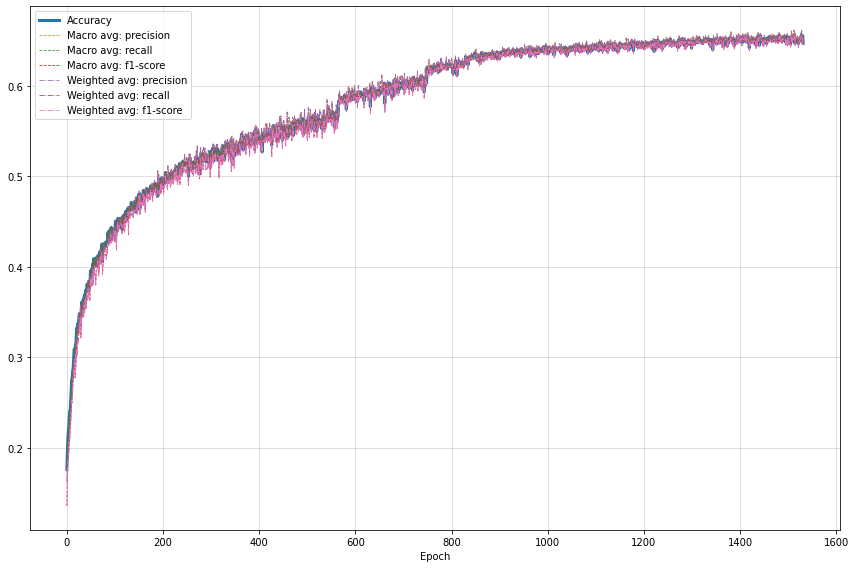

In [12]:
fig, ax1 = plt.subplots(1, 1, figsize=(12,8))

ax1.set_xlabel("Epoch")

ax1.plot(classification_report_log_dict['accuracy'], label = 'Accuracy', linewidth = 3)

ax1.plot(classification_report_log_dict['macro avg']['precision'], 
         label = 'Macro avg: precision', linestyle='--', linewidth = 0.8)
ax1.plot(classification_report_log_dict['macro avg']['recall'], 
         label = 'Macro avg: recall', linestyle='--', linewidth = 0.8)
ax1.plot(classification_report_log_dict['macro avg']['f1-score'], 
         label = 'Macro avg: f1-score', linestyle='--', linewidth = 0.8)

ax1.plot(classification_report_log_dict['weighted avg']['precision'], 
         label = 'Weighted avg: precision', linestyle='-.', linewidth = 0.8)
ax1.plot(classification_report_log_dict['weighted avg']['recall'], 
         label = 'Weighted avg: recall', linestyle='-.', linewidth = 0.8)
ax1.plot(classification_report_log_dict['weighted avg']['f1-score'], 
         label = 'Weighted avg: f1-score', linestyle='-.', linewidth = 0.8)


ax1.legend(loc='best')
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()

Then precision for each class:

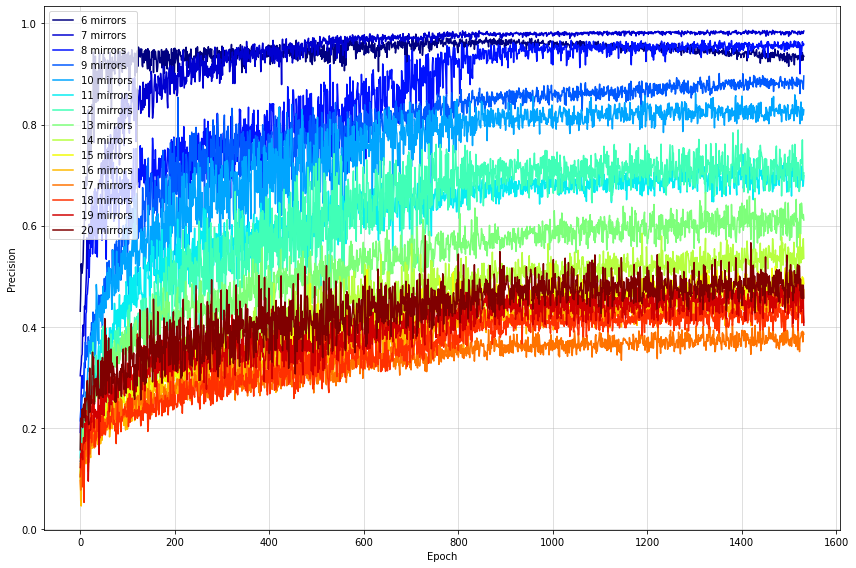

In [13]:
fig, ax1 = plt.subplots(1, 1, figsize=(12,8))

metric = "Precision"
ax1.set_ylabel(metric)
ax1.set_xlabel("Epoch")

for class_id, col in zip(classes, colors):
    class_metric = metric + ": " + class_id + " mirrors"
    ax1.plot(classification_report_log_dict[class_id]['precision'], 
             label = class_id + ' mirrors', color=col)
    
ax1.legend()
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()

Recall for each class:

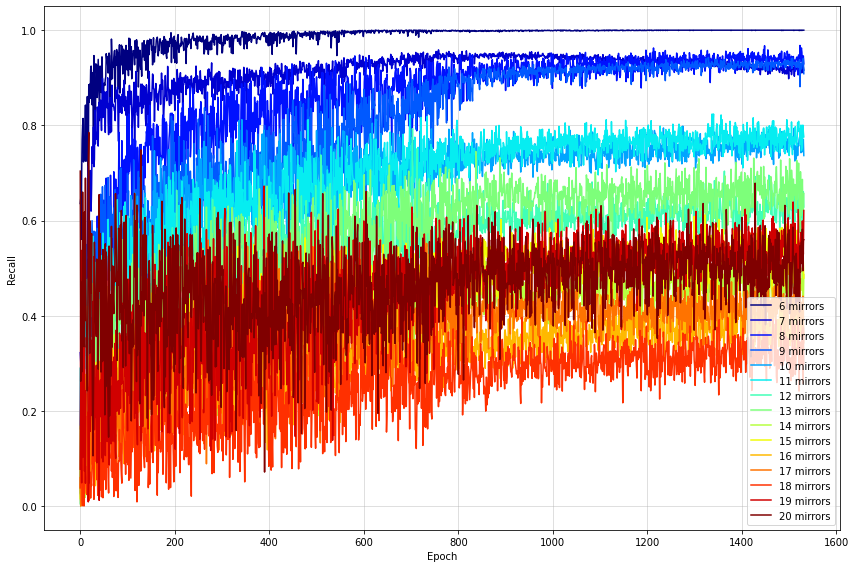

In [14]:
fig, ax1 = plt.subplots(1, 1, figsize=(12,8))

metric = "Recall"
ax1.set_ylabel(metric)
ax1.set_xlabel("Epoch")

for class_id, col in zip(classes, colors):
    class_metric = metric + ": " + class_id + " mirrors"
    ax1.plot(classification_report_log_dict[class_id]['recall'], 
             label = class_id + ' mirrors', color=col)
    
ax1.legend()
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()

And the F1 score for each class:

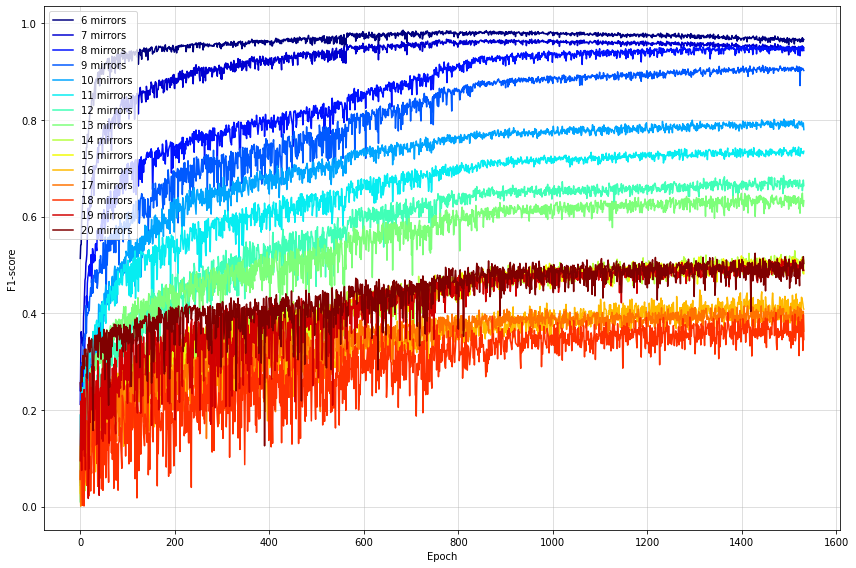

In [15]:
fig, ax1 = plt.subplots(1, 1, figsize=(12,8))

metric = "F1-score"
ax1.set_ylabel(metric)
ax1.set_xlabel("Epoch")

for class_id, col in zip(classes, colors):
    class_metric = metric + ": " + class_id + " mirrors"
    ax1.plot(classification_report_log_dict[class_id]['f1-score'], 
             label = class_id + ' mirrors', color=col)
    
ax1.legend()
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()

For completeness and convenience, we also output the final classification report in text form.

In [16]:
y_pred = model.predict(X_test, batch_size=len(X_test), verbose=1)
y_test_check = y_test
y_pred_check = np.argmax(y_pred, axis = 1)
print(classification_report(y_test_check, y_pred_check, target_names = classes))

1/1 [==============================] - 0s 44ms/step
              precision    recall  f1-score   support

           6       0.94      1.00      0.97      1500
           7       0.98      0.92      0.95      1500
           8       0.96      0.95      0.95      1500
           9       0.89      0.93      0.91      1500
          10       0.84      0.75      0.79      1500
          11       0.69      0.79      0.74      1500
          12       0.70      0.65      0.67      1500
          13       0.63      0.62      0.63      1500
          14       0.56      0.44      0.49      1500
          15       0.48      0.56      0.52      1500
          16       0.45      0.40      0.43      1500
          17       0.38      0.45      0.41      1500
          18       0.43      0.32      0.36      1500
          19       0.46      0.55      0.50      1500
          20       0.49      0.51      0.50      1500

    accuracy                           0.66     22500
   macro avg       0.66     

History for future reference:

In [17]:
print(classification_report_log_dict)

{'6': {'precision': [0.4306997742663657, 0.4658653846153846, 0.5246412975670618, 0.5089675230247213, 0.5059080962800875, 0.5183744055339387, 0.5306122448979592, 0.5737704918032787, 0.5800909550277918, 0.6184807256235828, 0.6179659266907589, 0.610923151280812, 0.6963484945547725, 0.6799557032115172, 0.6793598233995585, 0.6970842332613391, 0.7690763052208835, 0.829073482428115, 0.7209554831704669, 0.7470657276995305, 0.7426018983807928, 0.791256157635468, 0.749047359825803, 0.7425053533190579, 0.785014409221902, 0.8394160583941606, 0.7978971962616822, 0.8321766561514196, 0.9431239388794567, 0.7642626480086114, 0.8716032608695652, 0.8718791064388962, 0.9352226720647774, 0.8438256658595642, 0.8496894409937888, 0.8454987834549879, 0.9057665260196905, 0.8942498347653668, 0.8471720818291215, 0.9010033444816054, 0.9325108853410741, 0.941130906274206, 0.8885329916720052, 0.9218533886583679, 0.9215416379903648, 0.9221514508138712, 0.8922495274102079, 0.9128065395095368, 0.9267425320056899, 0.940